In [6]:
import jax.numpy as np
from jax import random
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [3]:
n_samples = 2000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
X = StandardScaler().fit_transform(X)

In [7]:
xlim, ylim = [-2, 2], [-2, 2]
plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
plt.xlim(xlim)
plt.ylim(ylim)

(-2.0, 2.0)

In [8]:
rng = random.PRNGKey(0)

/home/sam/programs/miniconda3/envs/norm_flow_smore/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Base Distribution

In [9]:
def sample_n01(N):
    D = 2
    return random.normal(rng, (N, D))

def log_prob_n01(x):
    return np.sum(-np.square(x)/2 - np.log(np.sqrt(2*np.pi)),axis=-1)

In [10]:
plt.hist(log_prob_n01(X))

(array([  2.,  14., 176., 562., 367., 133., 107., 117., 132., 390.]),
 array([-4.0142226, -3.8047435, -3.5952642, -3.385785 , -3.176306 ,
        -2.966827 , -2.7573476, -2.5478685, -2.3383894, -2.12891  ,
        -1.919431 ], dtype=float32),
 <BarContainer object of 10 artists>)

# Real NVP

In [11]:
from jax.experimental import stax # neural network library
from jax.experimental.stax import Dense, Relu # neural network layers

In [12]:
def nvp_forward(net_params, shift_and_log_scale_fn, x, flip=False):
    d = x.shape[-1]//2
    x1, x2 = x[:, :d], x[:, d:]
    if flip:
        x2, x1 = x1, x2
    shift, log_scale = shift_and_log_scale_fn(net_params, x1)
    y2 = x2*np.exp(log_scale) + shift
    if flip:
        x1, y2 = y2, x1
    y = np.concatenate([x1, y2], axis=-1)
    return y

In [13]:
def nvp_inverse(net_params, shift_and_log_scale_fn, y, flip=False):
    d = y.shape[-1]//2
    y1, y2 = y[:, :d], y[:, d:]
    if flip:
        y1, y2 = y2, y1
    shift, log_scale = shift_and_log_scale_fn(net_params, y1)
    x2 = (y2-shift)*np.exp(-log_scale)
    if flip:
        y1, x2 = x2, y1
    x = np.concatenate([y1, x2], axis=-1)
    return x, log_scale

In [15]:
def init_nvp():
    D = 2
    net_init, net_apply = stax.serial(
        Dense(512), 
        Relu, 
        Dense(512), 
        Relu, 
        Dense(D),
    )
    in_shape = (-1, D//2)
    out_shape, net_params = net_init(rng, in_shape)
    def shift_and_log_scale_fn(net_params, x1):
        s = net_apply(net_params, x1)
        return np.split(s, 2, axis=1)
    return net_params, shift_and_log_scale_fn

In [16]:
def sample_nvp(net_params, shift_log_scale_fn, base_sample_fn, N, flip=False):
    x = base_sample_fn(N)
    return nvp_forward(net_params, shift_log_scale_fn, x, flip=flip)

In [17]:
def log_prob_nvp(net_params, shift_log_scale_fn, base_log_prob_fn, y, flip=False):
    x, log_scale = nvp_inverse(net_params, shift_log_scale_fn, y, flip=flip)
    ildj = -np.sum(log_scale, axis=-1)
    return base_log_prob_fn(x) + ildj

In [18]:
def init_nvp_chain(n=2):
    flip = False
    ps, configs = [], []
    for i in range(n):
        p, f = init_nvp()
        ps.append(p), configs.append((f, flip))
        flip = not flip
    return ps, configs

In [19]:
def sample_nvp_chain(ps, configs, base_sample_fn, N):
    x = base_sample_fn(N)
    for p, config in zip(ps, configs):
        shift_log_scale_fn, flip = config
        x = nvp_forward(p, shift_log_scale_fn, x, flip=flip)
    return x

In [20]:
def make_log_prob_fn(p, log_prob_fn, config):
    shift_log_scale_fn, flip = config
    return lambda x: log_prob_nvp(p, shift_log_scale_fn, log_prob_fn, x, flip=flip)

In [21]:
def log_prob_nvp_chain(ps, configs, base_log_prob_fn, y):
    log_prob_fn = base_log_prob_fn
    for p, config in zip(ps, configs):
        log_prob_fn = make_log_prob_fn(p, log_prob_fn, config)
    return log_prob_fn(y)

In [44]:
ps, cs = init_nvp_chain(6)
y = sample_nvp_chain(ps, cs, sample_n01, 1000)

(array([  1.,  24.,  53., 142., 519., 494., 156., 115., 187., 309.]),
 array([-4.315003 , -4.084331 , -3.853659 , -3.6229868, -3.392315 ,
        -3.161643 , -2.930971 , -2.7002988, -2.469627 , -2.238955 ,
        -2.008283 ], dtype=float32),
 <BarContainer object of 10 artists>)

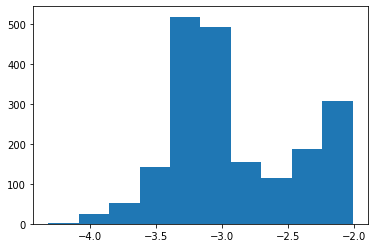

In [45]:
plt.hist(log_prob_nvp_chain(ps, cs, log_prob_n01, X))

# Train

In [74]:
from jax.experimental import optimizers
from jax import jit, grad
import numpy as onp
ps, cs = init_nvp_chain(8)

def loss(params, batch):
    return -np.mean(log_prob_nvp_chain(params, cs, log_prob_n01, batch))
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-4)

@jit
def step(i, opt_state, batch):
    params = get_params(opt_state)
    g = grad(loss)(params, batch)
    return opt_update(i, g, opt_state)

iters = int(1e3)
data_generator = (X[onp.random.choice(X.shape[0], 100)] for _ in range(iters))
opt_state = opt_init(ps)
for i in range(iters):
    opt_state = step(i, opt_state, next(data_generator))
ps = get_params(opt_state)

In [75]:
y = sample_nvp_chain(ps, cs, sample_n01, 1000)

In [76]:
y.max()

DeviceArray(2.1167352, dtype=float32)

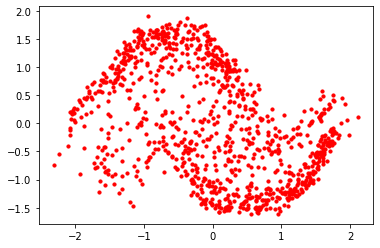

In [77]:
plt.scatter(y[:, 0], y[:, 1], s=10, color='red')
xlim, ylim = [-3, 3], [-3, 3]
plt.show()

# Animation

In [78]:
from matplotlib import animation, rc
from IPython.display import HTML, Image

In [79]:
x = sample_n01(1000)
values = [x]
for p, config in zip(ps, cs):
    shift_log_scale_fn, flip = config
    x = nvp_forward(p, shift_log_scale_fn, x, flip=flip)
    values.append(x)

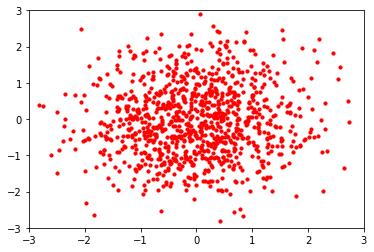

In [80]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
ax.set_xlim(xlim)
ax.set_ylim(ylim)

y = values[0]
paths = ax.scatter(y[:, 0], y[:, 1], s=10, color='red')

In [81]:
def animate(i):
    l = i//48
    t = (float(i%48))/48
    y = (1-t)*values[l] + t*values[l+1]
    paths.set_offsets(y)
    return (paths,)

In [87]:
anim = animation.FuncAnimation(fig, animate, frames=24*len(cs), interval=0.001, blit=False)

In [89]:
anim.save('anim6.gif', fps=120)

In [90]:
Image(url='anim6.gif')